Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


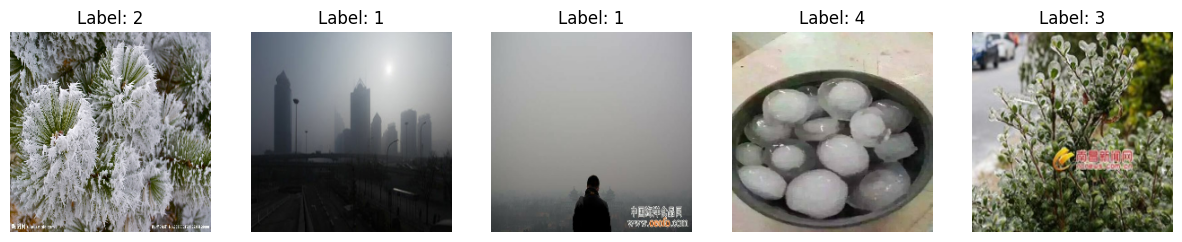

In [166]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt


# Dataset/hyperparams
sandbox_dir = "Data/Weather_Dataset"
batch_size = 32
image_size = (224, 224) #do not change for resnet50

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="both",
    seed=1234,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

### USE THESE 
train_dataset, val_dataset = dataset 
 
class_names = train_dataset.class_names

# print first 5 of training set
for images, labels in train_dataset.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].numpy()}")
    plt.show()
    break

In [167]:
# Convert the train dataset into two lists for images and labels
X_train, X_test, Y_train, Y_test = [], [], [], []

# Iterate through the batches
for images, labels in train_dataset:
    X_train.append(images)
    Y_train.append(labels)

# Iterate through the batches
for images, labels in val_dataset:
    X_test.append(images)
    Y_test.append(labels)

# Convert lists to TensorFlow tensors
X_train = tf.concat(X_train, axis=0)  # Combine batches into one tensor
Y_train = tf.concat(Y_train, axis=0)  # Combine labels into one tensor
X_test = tf.concat(X_test, axis=0)  # Combine batches into one tensor
Y_test = tf.concat(Y_test, axis=0)  # Combine labels into one tensor

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

2025-02-27 22:24:57.108109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-02-27 22:24:57.891229: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-02-27 22:24:59.349164: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-02-27 22:25:01.172990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-27 22:25:03.399830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train shape: (5490, 224, 224, 3)
Y_train shape: (5490,)
X_test shape: (1372, 224, 224, 3)
Y_test shape: (1372,)


Class Names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


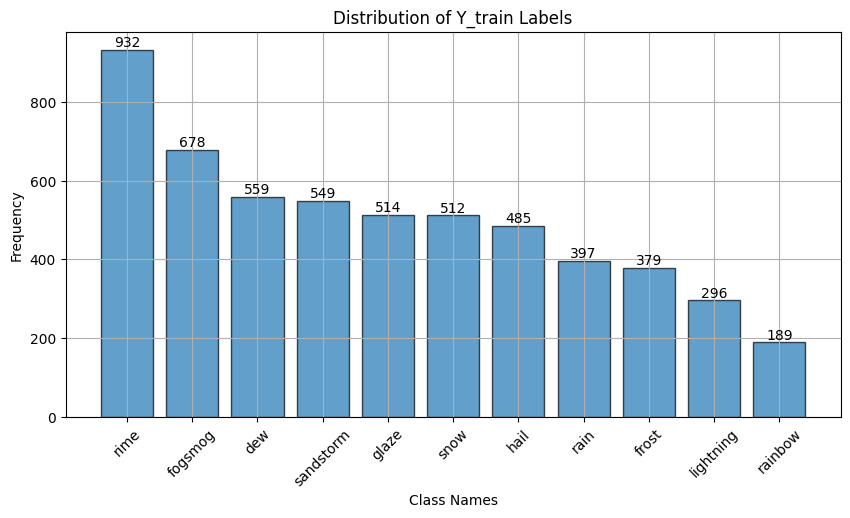

In [168]:
# Get class names from the dataset
class_names = train_dataset.class_names
print("Class Names:", class_names)

# Convert Tensor to NumPy array
Y_train_np = Y_train.numpy()

# Create a dictionary to map label indices to folder names
label_to_class = {i: class_names[i] for i in range(len(class_names))}

# Map labels to class names
Y_train_classes = [label_to_class[label] for label in Y_train_np]

# Count the frequency of each class
class_counts = {class_name: Y_train_classes.count(class_name) for class_name in class_names}

# Sort the class counts by frequency
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the distribution with class names
plt.figure(figsize=(10, 5))
bars = plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), edgecolor='black', alpha=0.7)
plt.title("Distribution of Y_train Labels")
plt.xlabel("Class Names")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(rotation=45)

# Label the frequencies on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.show()

In [181]:
# Get class names from the dataset
class_names = train_dataset.class_names

# Convert Tensor to NumPy array
X_train_np = X_train.numpy()
Y_train_np = Y_train.numpy()

# Create a dictionary to map label indices to folder names
label_to_class = {i: class_names[i] for i in range(len(class_names))}

# Map labels to class names
Y_train_classes = [label_to_class[label] for label in Y_train_np]

# Plot the first 5 images with their corresponding labels
# plt.figure(figsize=(15, 5))
# for i in range(5):
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(X_train_np[i].astype("uint8"))
#     plt.title(Y_train_classes[i])
#     plt.axis('off')
# plt.show()

In [170]:
# Normalize the pixel values to [0, 1]
X_train = tf.cast(X_train, tf.float32) / 255.0
X_test = tf.cast(X_test, tf.float32) / 255.0

# Flatten the images using TensorFlow
X_train = tf.reshape(X_train, (tf.shape(X_train)[0], -1))
X_test = tf.reshape(X_test, (tf.shape(X_test)[0], -1))

# Print the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (5490, 150528)
X_test shape: (1372, 150528)


In [171]:
def build_model(num_features, learning_rate):
  """Build a TF logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=11,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='softmax',     # softmax activation function for mutliclass classification
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['f1_score', 'auc', 'categorical_accuracy', 'precision', 'recall'])  # Categorical cross entropy (multiclass log loss)

  return model

In [172]:
tf.random.set_seed(1234)
from keras.utils import to_categorical


Y_train_encoded = to_categorical(np.array(Y_train))
model= build_model(X_train.shape[1], learning_rate=0.0001)

model_history = model.fit(X_train, Y_train_encoded, epochs=30, batch_size=32)

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - auc: 0.7154 - categorical_accuracy: 0.2780 - f1_score: 0.1785 - loss: 2.1233 - precision: 0.5683 - recall: 0.0187
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - auc: 0.8294 - categorical_accuracy: 0.4334 - f1_score: 0.3079 - loss: 1.7669 - precision: 0.7547 - recall: 0.1187
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - auc: 0.8509 - categorical_accuracy: 0.4668 - f1_score: 0.3531 - loss: 1.6615 - precision: 0.7812 - recall: 0.1843
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - auc: 0.8610 - categorical_accuracy: 0.4886 - f1_score: 0.3864 - loss: 1.6064 - precision: 0.7830 - recall: 0.2187
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - auc: 0.8676 - categorical_accuracy: 0.5026 - f1_score: 0.4088 - loss: 1.5700 - precision: 0.7847 - recall: 0.2387
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.8724 - categorical_accuracy: 0.5162 - f1_score: 0.4310 - loss: 1.5430 - precision: 0.7918 - r

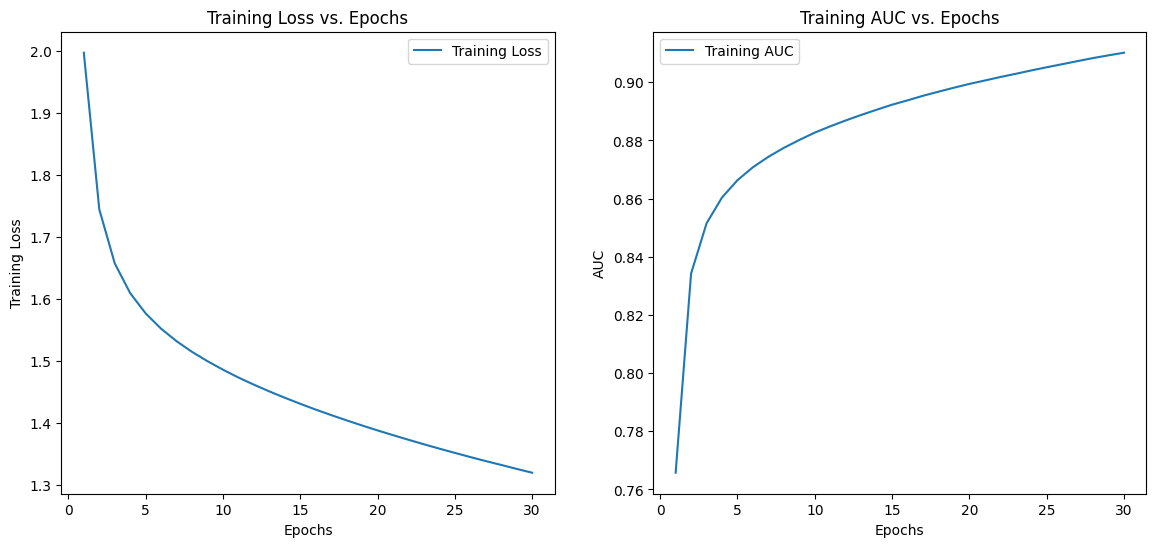

In [173]:
# Extract metrics from the history object
epochs = range(1, len(model_history.history['loss']) + 1)
training_loss = model_history.history['loss']
training_auc = model_history.history['auc']

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Plot Training AUC
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

# Plot Validation AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, training_auc, label='Training AUC')
plt.title('Training AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

# Show the plots
plt.show()

# With 5-Fold Cross-Validation

In [174]:
# Convert TensorFlow tensors to NumPy arrays
X_train_np = X_train.numpy()
Y_train_np = Y_train.numpy()

# One-hot encode the labels
Y_train_encoded = to_categorical(Y_train_np)

# Define the number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to store average metrics
avg_val_loss, avg_val_f1, avg_val_auc, avg_val_acc, avg_val_prec, avg_val_rec = 0, 0, 0, 0, 0, 0
all_true_labels, all_pred_labels = [], []

# Perform k-fold cross-validation
fold_no = 1
for train_index, val_index in kf.split(X_train_np):
    print(f"Training fold {fold_no}...")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
    Y_train_fold, Y_val_fold = Y_train_encoded[train_index], Y_train_encoded[val_index]
    
    # Build and train the model
    model = build_model(X_train_fold.shape[1], learning_rate=0.0001)
    model.fit(X_train_fold, Y_train_fold, epochs=30, batch_size=32, validation_data=(X_val_fold, Y_val_fold))
    
    # Evaluate the model on the validation set
    val_metrics = model.evaluate(X_val_fold, Y_val_fold)
    print(f"Fold {fold_no} - Validation Metrics: {val_metrics}")
    
    val_loss, val_precision, val_recall, val_auc, val_accuracy = val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3], val_metrics[4]
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
    
    print(f"Fold {fold_no} - Validation Loss: {val_loss}, Validation Precision: {val_precision}, Validation Recall: {val_recall}, Validation AUC: {val_auc}, Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}")
    
    # Predict the labels for the validation set
    Y_val_pred = model.predict(X_val_fold)
    Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
    Y_val_true_classes = np.argmax(Y_val_fold, axis=1)
    
    # Collect all true and predicted labels
    all_true_labels.extend(Y_val_true_classes)
    all_pred_labels.extend(Y_val_pred_classes)

    # Accumulate metrics
    avg_val_loss += val_loss
    avg_val_f1 += (2 * val_precision * val_recall) / (val_precision + val_recall)
    avg_val_auc += val_auc
    avg_val_acc += val_accuracy
    avg_val_prec += val_precision
    avg_val_rec += val_recall
    
    fold_no += 1

# Calculate the average validation metrics
avg_val_loss /= k
avg_val_auc /= k
avg_val_acc /= k
avg_val_rec /= k
avg_val_prec = np.mean(avg_val_prec)
avg_val_f1 = np.mean(avg_val_f1)

print(f"Average 5-Fold Cross Validation Loss: {avg_val_loss}")
print(f"Average 5-Fold Cross Validation F1 Score: {avg_val_f1}")
print(f"Average 5-Fold Cross Validation AUC: {avg_val_auc}")
print(f"Average 5-Fold Cross Validation Accuracy: {avg_val_acc}")
print(f"Average 5-Fold Cross Validation Precision: {avg_val_prec}")
print(f"Average 5-Fold Cross Validation Recall: {avg_val_rec}")

Training fold 1...
Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - auc: 0.6919 - categorical_accuracy: 0.2563 - f1_score: 0.1673 - loss: 2.1630 - precision: 0.5434 - recall: 0.0113 - val_auc: 0.8160 - val_categorical_accuracy: 0.4080 - val_f1_score: 0.2702 - val_loss: 1.8919 - val_precision: 0.7705 - val_recall: 0.0428
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - auc: 0.8181 - categorical_accuracy: 0.4167 - f1_score: 0.2981 - loss: 1.8291 - precision: 0.7478 - recall: 0.0833 - val_auc: 0.8342 - val_categorical_accuracy: 0.4381 - val_f1_score: 0.3357 - val_loss: 1.7839 - val_precision: 0.7500 - val_recall: 0.1011
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - auc: 0.8416 - categorical_accuracy: 0.4500 - f1_score: 0.3390 - loss: 1.7203 - precision: 0.7732 - recall: 0.1428 - val_auc: 0.8401 - val_categorical_accuracy: 0.4572 - val_f1_score: 0.3660 - val_loss: 1.7354 - val_precision: 0.7430 - val_recall: 0.1448
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step 

In [176]:

print(f"Average 5-Fold Cross Validation Loss: {avg_val_loss}")
print(f"Average 5-Fold Cross Validation F1 Score: {np.mean(avg_val_f1)}")
print(f"Average 5-Fold Cross Validation AUC: {avg_val_auc}")
print(f"Average 5-Fold Cross Validation Accuracy: {avg_val_acc}")
print(f"Average 5-Fold Cross Validation Precision: {np.mean(avg_val_prec)}")
print(f"Average 5-Fold Cross Validation Recall: {avg_val_rec}")

Average 5-Fold Cross Validation Loss: 1.536372447013855
Average 5-Fold Cross Validation F1 Score: 2.834247589111328
Average 5-Fold Cross Validation AUC: 0.5171220421791076
Average 5-Fold Cross Validation Accuracy: 0.738992428779602
Average 5-Fold Cross Validation Precision: 2.2925424575805664
Average 5-Fold Cross Validation Recall: 0.8716226816177368


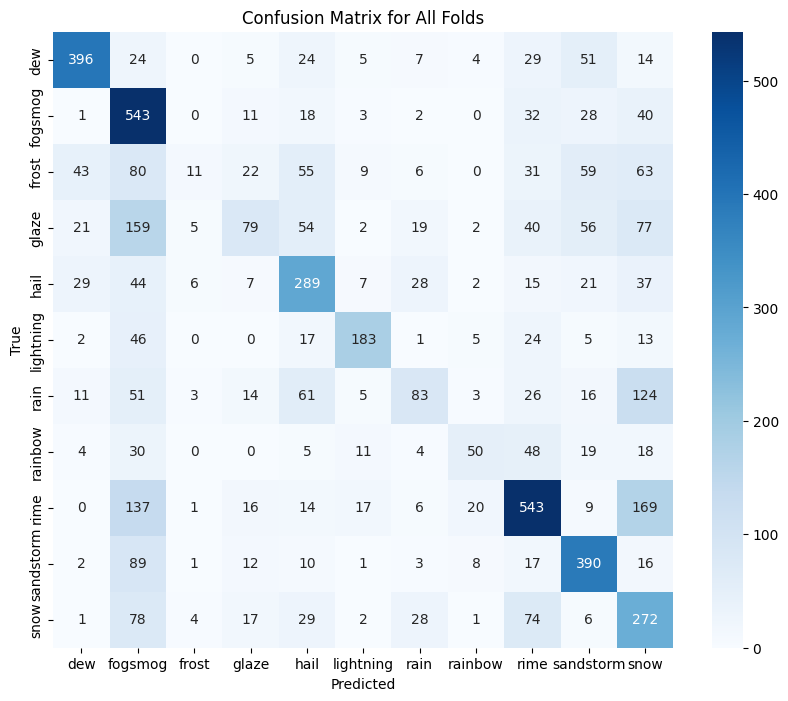

In [180]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix for all folds
cm = confusion_matrix(all_true_labels, all_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for All Folds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()